In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [2]:
train = pl.read_csv("/kaggle/input/atmaCup#18_dataset/train_features.csv")
train = (
    train.with_columns(
        pl.col("ID").str.split_exact("_", n=1).struct.rename_fields(["sceneID", "offset"]).alias("fields")
    )
    .unnest("fields")
    .with_columns(pl.col("offset").cast(pl.Float32))
)
print(train.shape)
train.head()

(43371, 32)


shape: (5, 32)
┌────────────┬───────────┬───────────┬────────────┬───┬───────────┬──────────┬────────────┬────────┐
│ ID         ┆ vEgo      ┆ aEgo      ┆ steeringAn ┆ … ┆ y_5       ┆ z_5      ┆ sceneID    ┆ offset │
│ ---        ┆ ---       ┆ ---       ┆ gleDeg     ┆   ┆ ---       ┆ ---      ┆ ---        ┆ ---    │
│ str        ┆ f64       ┆ f64       ┆ ---        ┆   ┆ f64       ┆ f64      ┆ str        ┆ f32    │
│            ┆           ┆           ┆ f64        ┆   ┆           ┆          ┆            ┆        │
╞════════════╪═══════════╪═══════════╪════════════╪═══╪═══════════╪══════════╪════════════╪════════╡
│ 00066be8e2 ┆ 5.701526  ┆ 1.538456  ┆ -2.165777  ┆ … ┆ 0.199503  ┆ 0.485079 ┆ 00066be8e2 ┆ 320.0  │
│ 0318869c38 ┆           ┆           ┆            ┆   ┆           ┆          ┆ 0318869c38 ┆        │
│ c66be46663 ┆           ┆           ┆            ┆   ┆           ┆          ┆ c66be46663 ┆        │
│ …          ┆           ┆           ┆            ┆   ┆           ┆          ┆ …          ┆        │
│ 00066be8e2 ┆ 11.176292 ┆ 0.279881  ┆ -11.625697 ┆ … ┆ 1.42507   ┆ 0.073083 ┆ 00066be8e2 ┆ 420.0  │
│ 0318869c38 ┆           ┆           ┆            ┆   ┆           ┆          ┆ 0318869c38 ┆        │
│ c66be46663 ┆           ┆           ┆            ┆   ┆           ┆          ┆ c66be46663 ┆        │
│ …          ┆           ┆           ┆            ┆   ┆           ┆          ┆ …          ┆        │
│ 00066be8e2 ┆ 10.472548 ┆ 0.231099  ┆ -2.985105  ┆ … ┆ -0.841894 ┆ 0.152889 ┆ 00066be8e2 ┆ 520.0  │
│ 0318869c38 ┆           ┆           ┆            ┆   ┆           ┆          ┆ 0318869c38 ┆        │
│ c66be46663 ┆           ┆           ┆            ┆   ┆           ┆          ┆ c66be46663 ┆        │
│ …          ┆           ┆           ┆            ┆   ┆           ┆          ┆ …          ┆        │
│ 000fb056f9 ┆ 6.055565  ┆ -0.117775 ┆ 7.632668   ┆ … ┆ 1.374655  ┆ 0.058754 ┆ 000fb056f9 ┆ 120.0  │
│ 7572d384ba ┆           ┆           ┆            ┆   ┆           ┆          ┆ 7572d384ba ┆        │
│ e4f5fc1e0f ┆           ┆           ┆            ┆   ┆           ┆          ┆ e4f5fc1e0f ┆        │
│ …          ┆           ┆           ┆            ┆   ┆           ┆          ┆ …          ┆        │
│ 000fb056f9 ┆ 3.316744  ┆ 1.276733  ┆ -31.725477 ┆ … ┆ -0.7788   ┆ 0.044243 ┆ 000fb056f9 ┆ 20.0   │
│ 7572d384ba ┆           ┆           ┆            ┆   ┆           ┆          ┆ 7572d384ba ┆        │
│ e4f5fc1e0f ┆           ┆           ┆            ┆   ┆           ┆          ┆ e4f5fc1e0f ┆        │
│ …          ┆           ┆           ┆            ┆   ┆           ┆          ┆ …          ┆        │
└────────────┴───────────┴───────────┴────────────┴───┴───────────┴──────────┴────────────┴────────┘

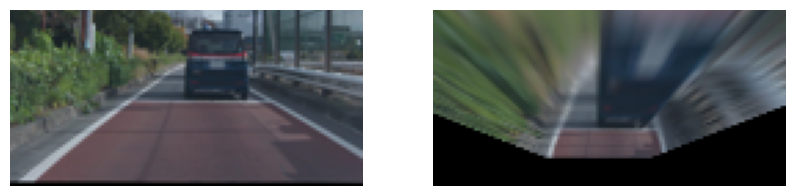

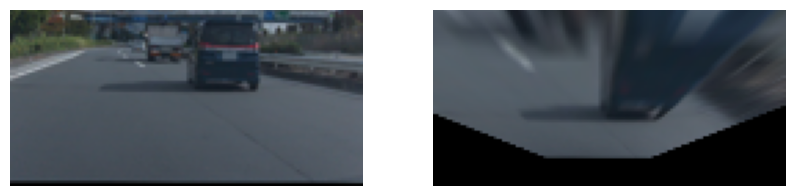

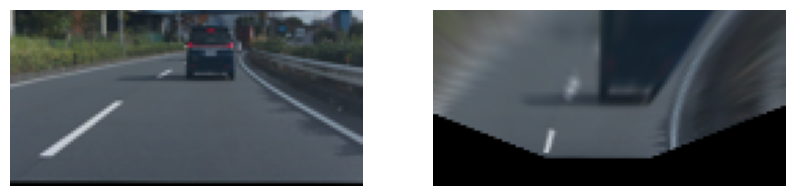

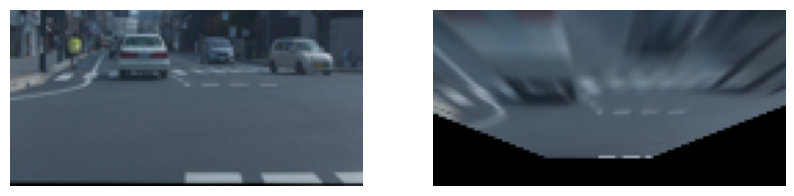

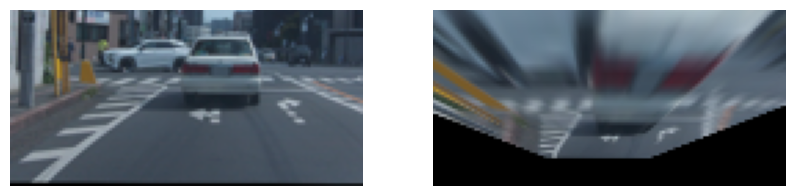

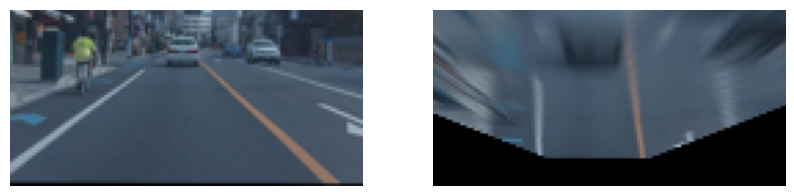

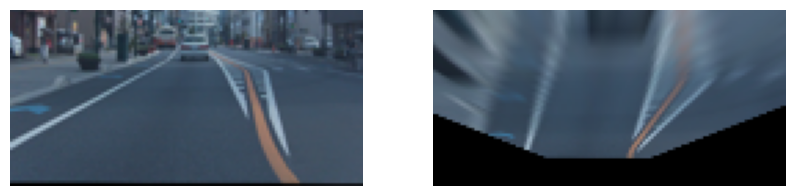

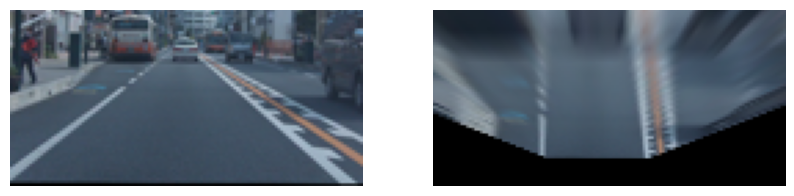

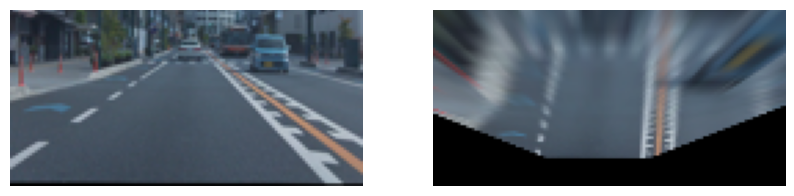

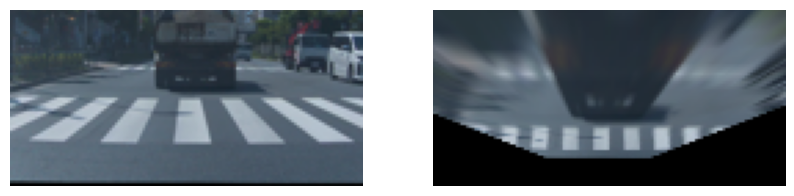

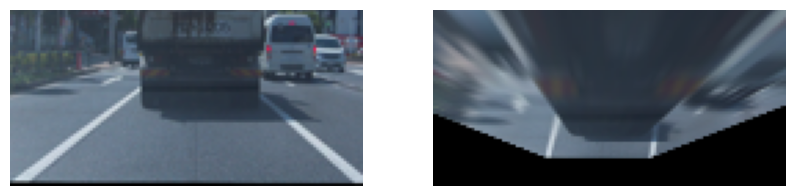

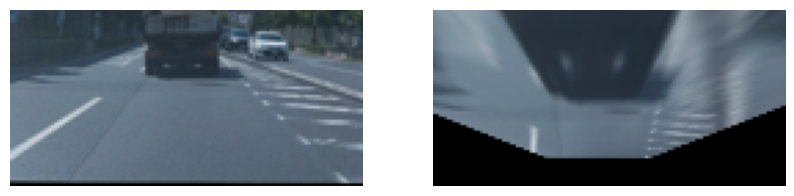

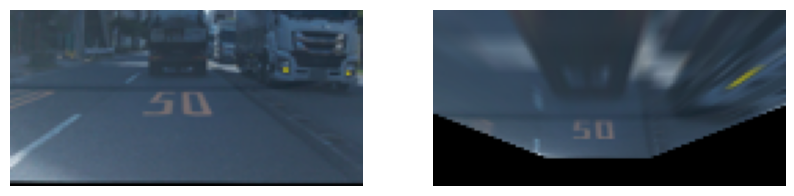

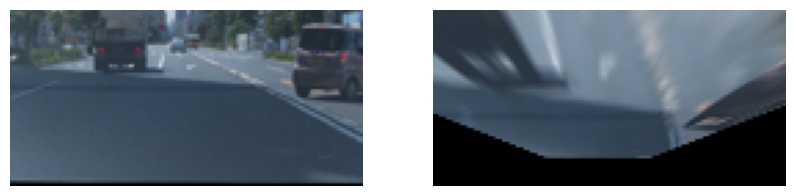

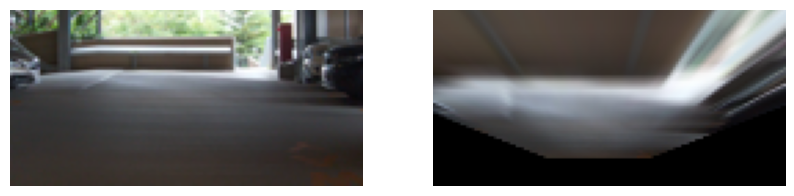

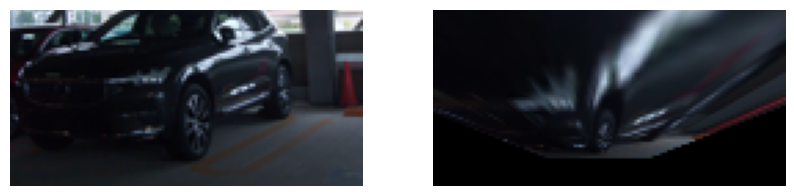

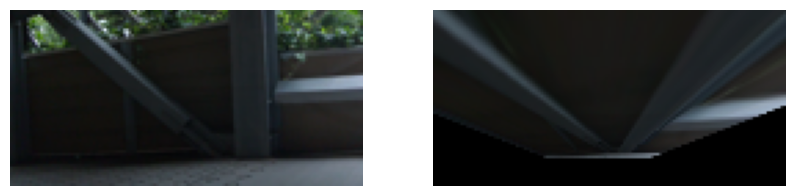

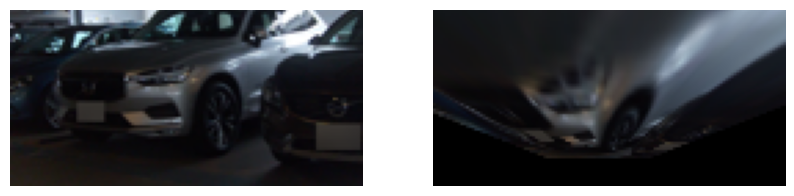

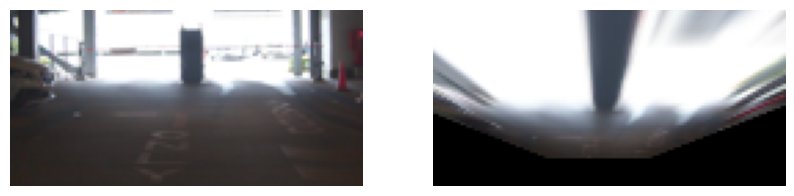

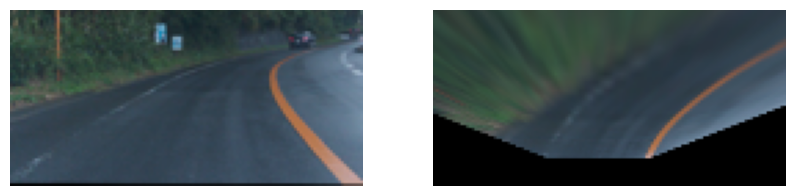

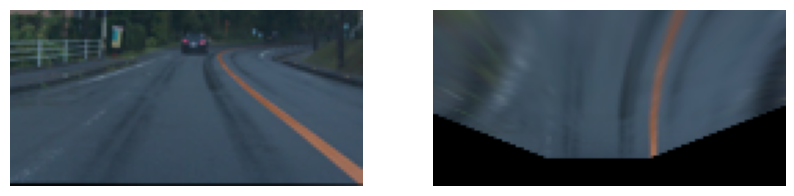

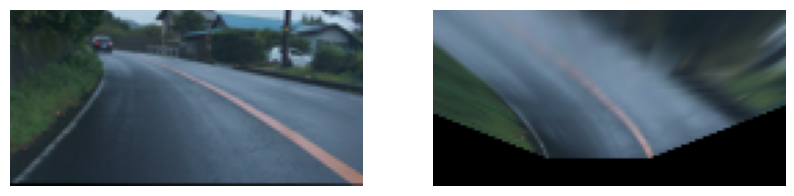

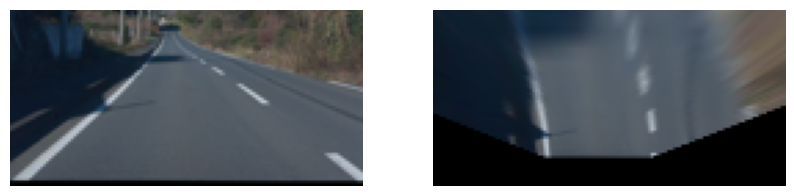

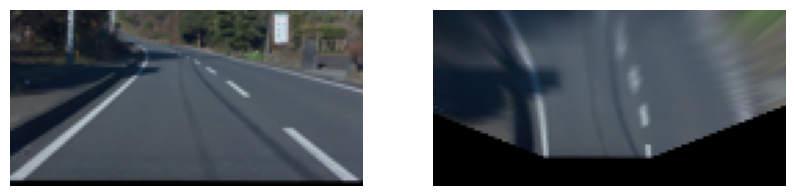

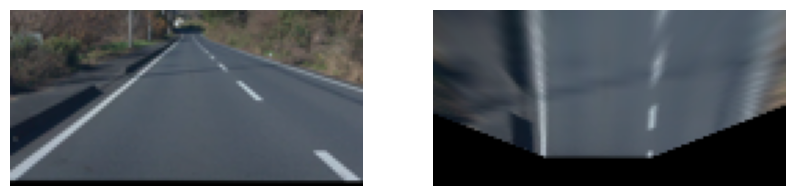

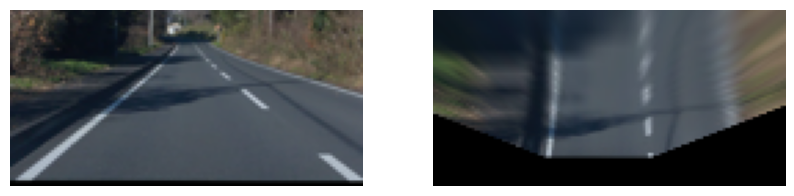

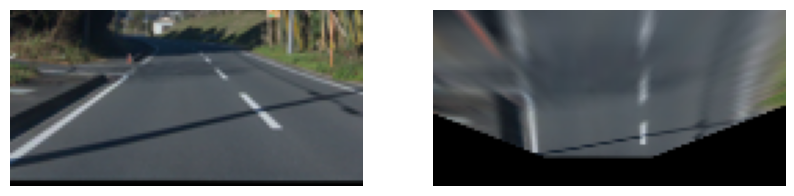

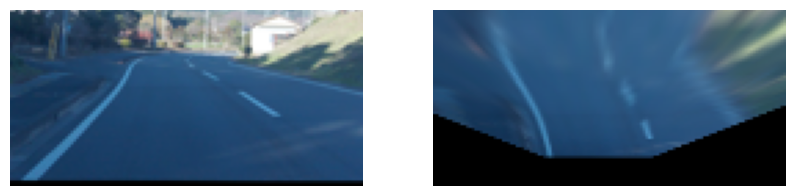

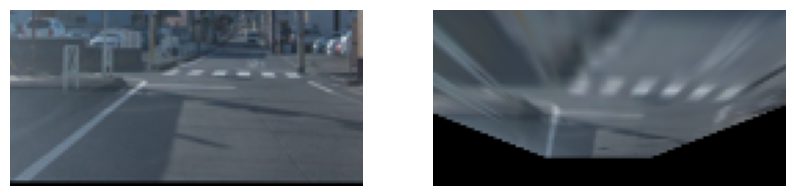

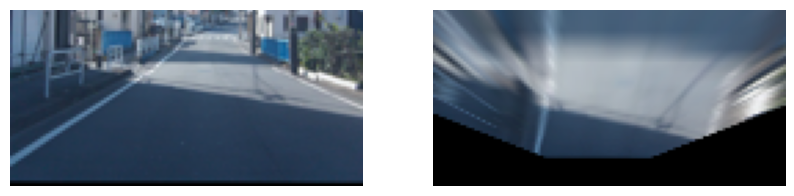

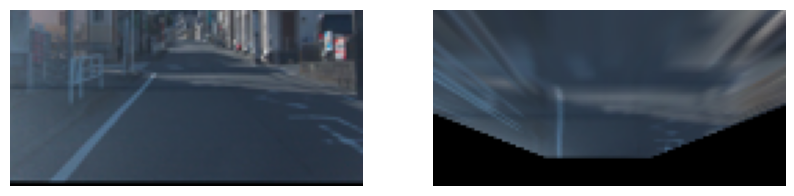

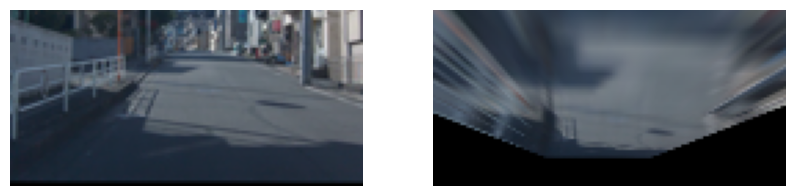

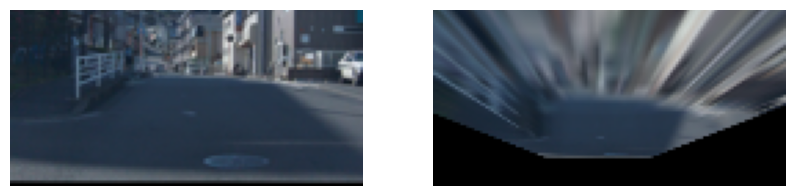

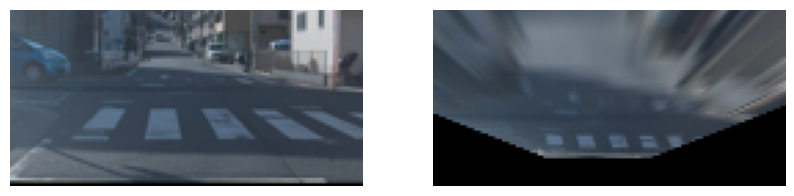

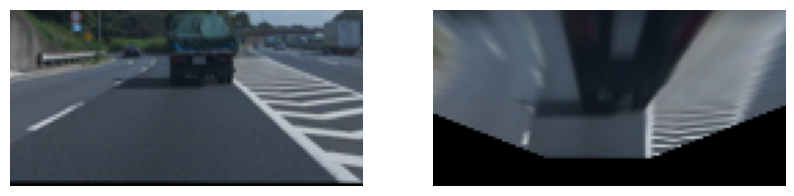

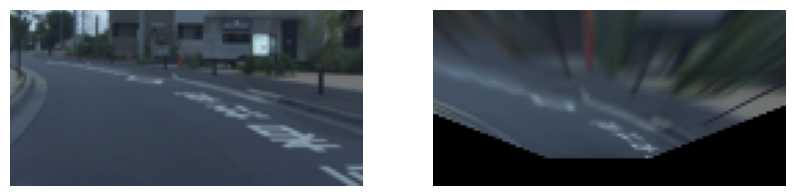

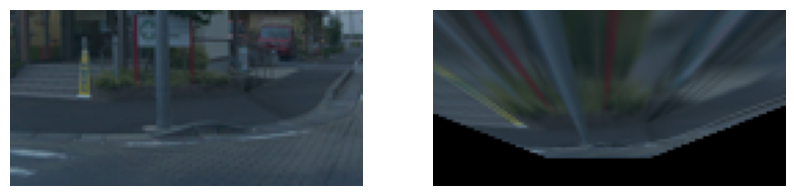

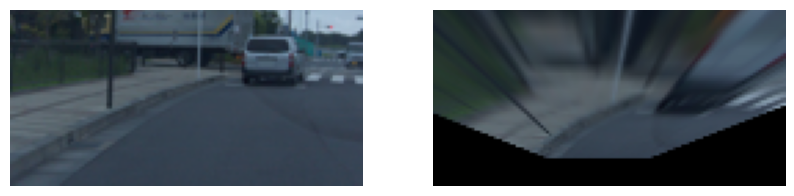

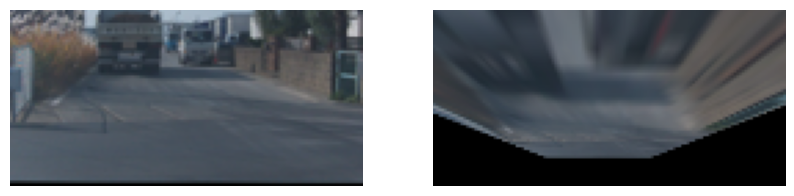

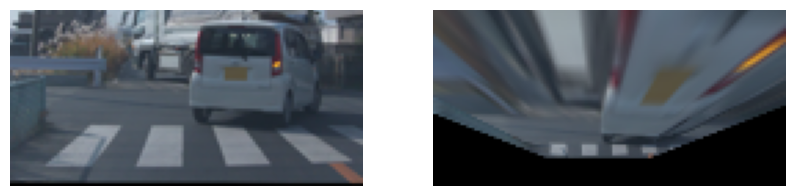

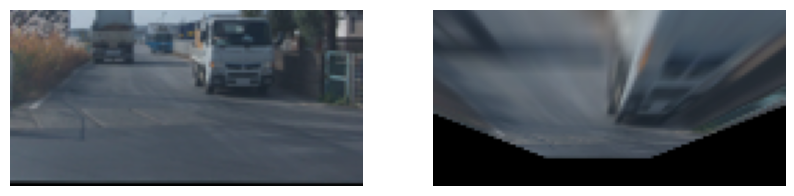

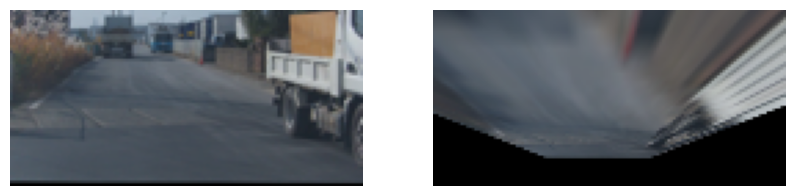

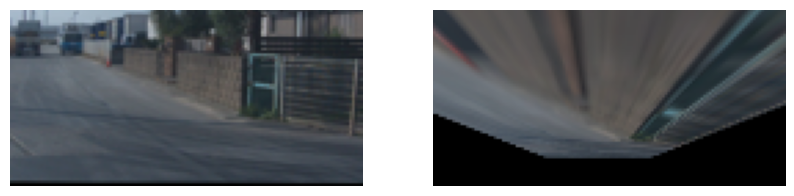

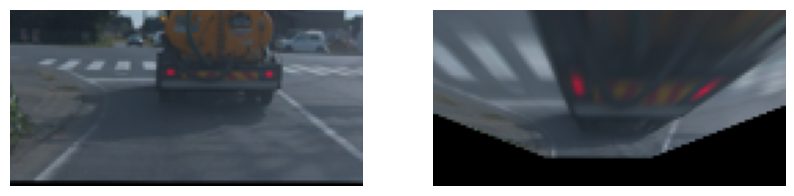

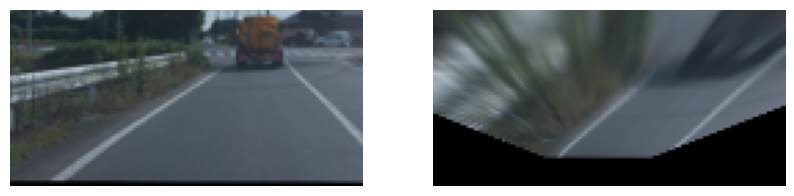

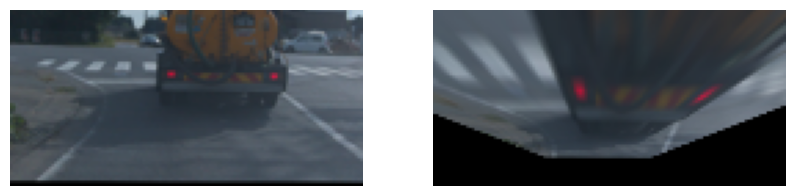

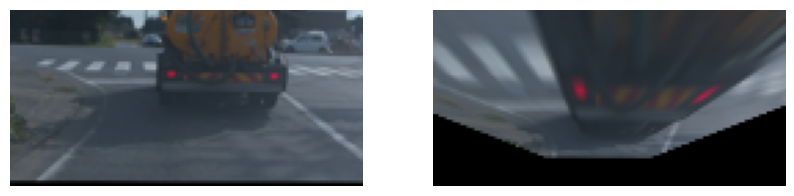

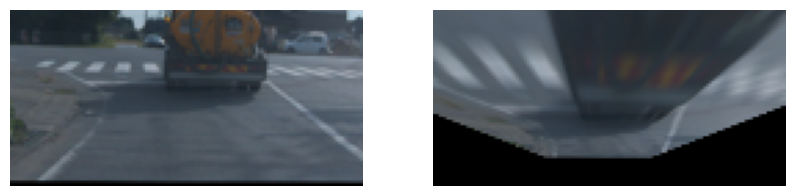

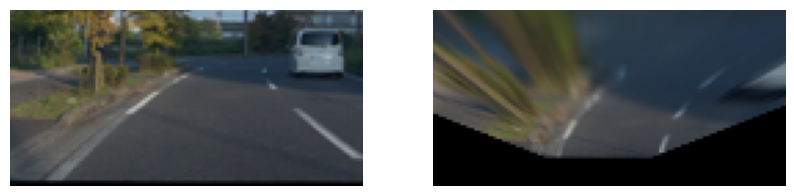

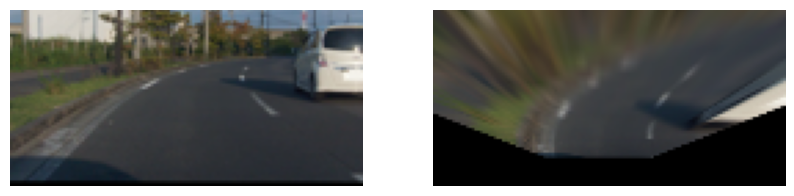

In [3]:
def homography_transform(image):
    height, width = image.shape[:2]
    src_pts = np.array([[20, 50], [128, 50], [42, 30], [95, 30]], dtype=np.float64)
    dst_pts = np.array([[100, 200], [200, 200], [100, 160], [200, 160]], dtype=np.float64)

    n = src_pts.shape[0]
    A = []
    for i in range(n):
        x, y = src_pts[i][0], src_pts[i][1]
        x_p, y_p = dst_pts[i][0], dst_pts[i][1]
        A.append([-x, -y, -1, 0, 0, 0, x * x_p, y * x_p, x_p])
        A.append([0, 0, 0, -x, -y, -1, x * y_p, y * y_p, y_p])
    A = np.array(A)
    U, S, Vh = np.linalg.svd(A)
    h = Vh[-1, :] / Vh[-1, -1]  # 正規化
    H = h.reshape(3, 3)

    warped_image = cv2.warpPerspective(image, H, (300, 250))
    warped_image = cv2.resize(warped_image, (width, height))
    return warped_image


for ID in train["ID"][:50]:
    path = os.path.join("/kaggle/input/atmaCup#18_dataset", "images", ID, "image_t.png")
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs[0].imshow(image)
    axs[0].axis("off")
    axs[1].imshow(homography_transform(image))
    axs[1].axis("off")
    plt.show()

In [5]:
from tqdm import tqdm

# save
os.makedirs("plane", exist_ok=True)
for ID in tqdm(train["ID"]):
    path = os.path.join("/kaggle/input/atmaCup#18_dataset", "images", ID, "image_t.png")
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    warped_image = homography_transform(image)
    cv2.imwrite(f"plane/{ID}.png", cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR))

100%|██████████| 43371/43371 [00:39<00:00, 1107.11it/s]
